In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin 

In [3]:
df = pd.read_csv('./Customer-Churn-Records.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [4]:
# Check for uniqueness

print('Lenght of data frame:', df.shape[0])
print('Unique Customer id:', df.RowNumber.unique().shape[0])

Lenght of data frame: 10000
Unique Customer id: 10000


In [5]:
df.columns 

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
       'Satisfaction Score', 'Card Type', 'Point Earned'],
      dtype='object')

In [6]:
# choosing relevant columns

df_input = df[['CreditScore', 'Geography', 'Gender','Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Complain',
       'Satisfaction Score', 'Card Type', 'Point Earned', 'Exited']]

# One hot encoding Gender, Geography and Card Type
df_input = pd.get_dummies(df_input, drop_first=True).astype(int)
df_input.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Point Earned,Exited,Geography_Germany,Geography_Spain,Gender_Male,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,619,42,2,0,1,1,1,101348,1,2,464,1,0,0,0,0,0,0
1,608,41,1,83807,1,0,1,112542,1,3,456,0,0,1,0,0,0,0
2,502,42,8,159660,3,1,0,113931,1,3,377,1,0,0,0,0,0,0
3,699,39,1,0,2,0,0,93826,0,5,350,0,0,0,0,1,0,0
4,850,43,2,125510,1,1,1,79084,0,5,425,0,0,1,0,1,0,0


In [7]:
X = df_input.drop(columns=['Exited'])
y = df_input['Exited']

In [8]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7500, 17)
(2500, 17)
(7500,)
(2500,)


<Axes: >

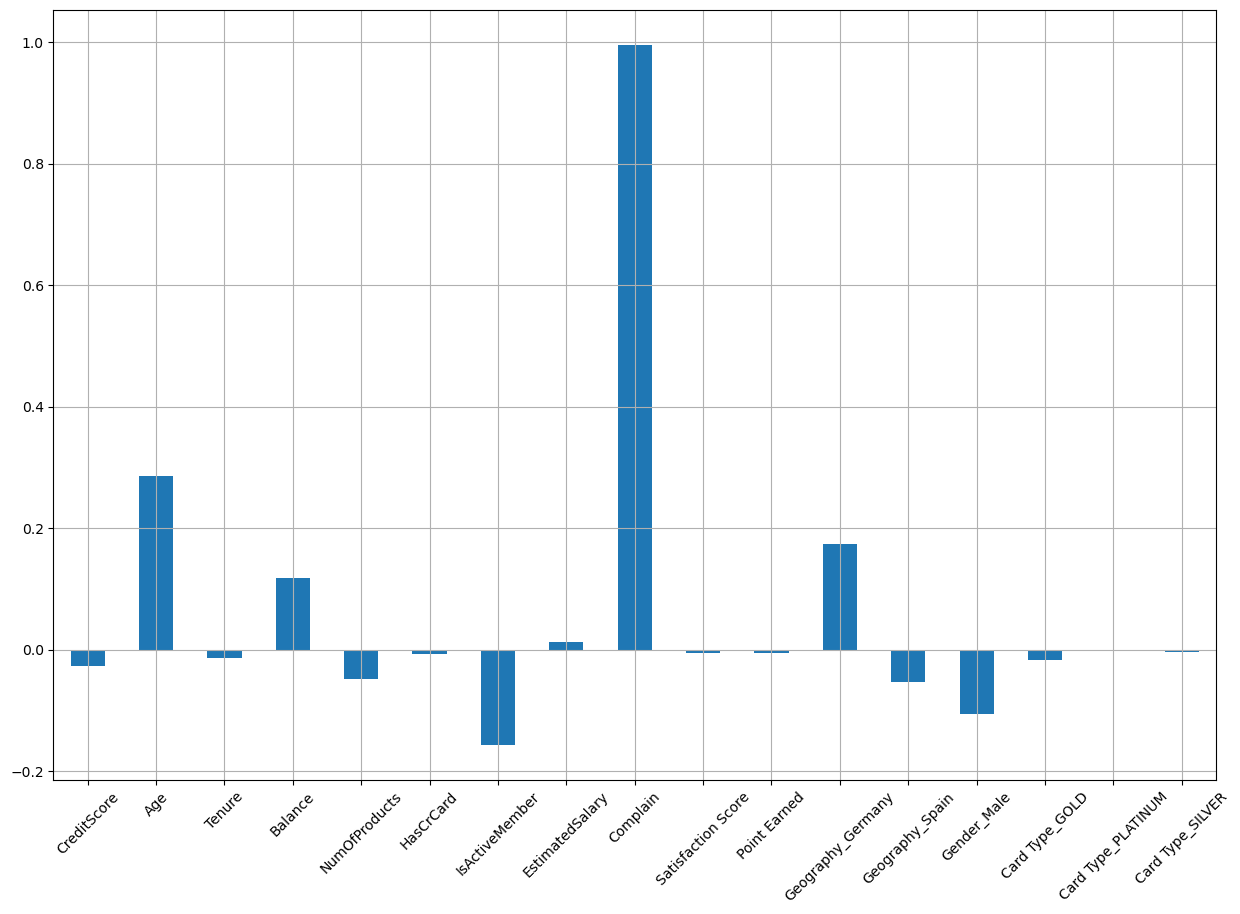

In [9]:
# check for multicollinearity 

X.corrwith(df_input['Exited']).plot.bar(figsize=(15, 10), rot=45, grid=True)

<Axes: >

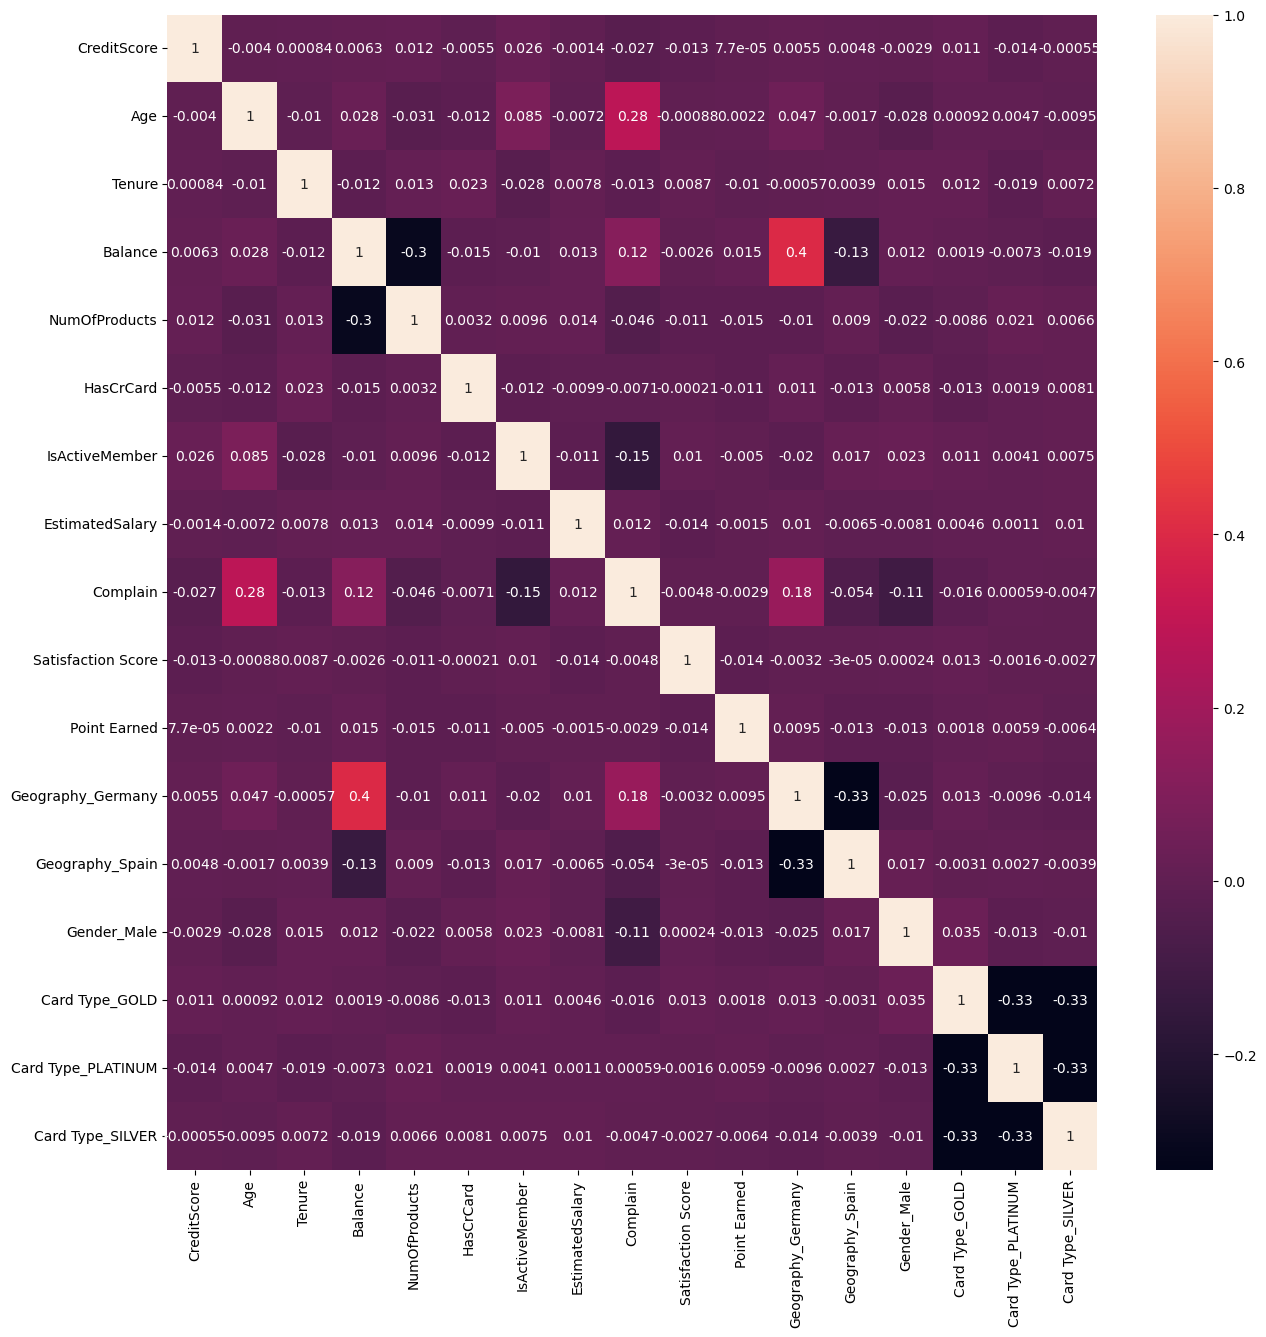

In [10]:
# Correlation matrix 

corr = X.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True)

In [11]:
# set-up scaling
# only non-binary columns should be scaled

columns_to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'Satisfaction Score',
       'Point Earned']

In [12]:
# Set up a pipeline to avoid information leak
# A CustomScaler is needed to only scale some of the columns 
# and pass it through a pipeline

class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns) -> None:
        self.scaler = StandardScaler()
        self.columns = columns 

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self
    
    def transform(self, X):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns, index=X.index)
        X_not_scaled = X.drop(self.columns, axis=1)
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]


## SVC with StandardScaler

In [13]:

pipe = Pipeline([('scaler', CustomScaler(columns_to_scale)), ('svm', SVC())])

param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

grid.fit(X_train, y_train)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))


Best cross-validation accuracy: 0.80
Test set score: 0.80
Best parameters: {'svm__C': 0.001, 'svm__gamma': 0.001}


# LogisticRegression with StandarScaler

In [14]:
pipe2 = Pipeline([('scaler', CustomScaler(columns_to_scale)), ('logreg', LogisticRegression())])
param_grid2 = {'logreg__C': [0.01, 0.1, 1, 10, 100]} 
grid2 = GridSearchCV(pipe2, param_grid=param_grid2, cv=5)

grid2.fit(X_train, y_train)

print("Best cross-validation accuracy: {:.2f}".format(grid2.best_score_))
print("Test set score: {:.2f}".format(grid2.score(X_test, y_test)))
print("Best parameters: {}".format(grid2.best_params_))

Best cross-validation accuracy: 0.89
Test set score: 0.89
Best parameters: {'logreg__C': 1}


## RandomForestClassifier

In [15]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

print(f"Accuracy on Training set: {rfc.score(X_train, y_train)}")
print(f"Accuracy on Test set: {rfc.score(X_test, y_test)}")

Accuracy on Training set: 1.0
Accuracy on Test set: 0.9984


In [17]:
# check cross validation score on RandomForestClassifer

avg_cv = np.mean(cross_val_score(rfc, X_train, y_train))

print(f'Average cross-validation score: {avg_cv}')



Average cross-validation score: 0.9986666666666666


### The RandomForestClassifer performs far better than the SVC and LogisticRegression